In [1]:
import numpy as np
import random 
from datetime import datetime
from numpy import genfromtxt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Select S&P500 (Symbol = SPX) Dataset from 4 Jan 1960 to 11 Mar 2022

In [2]:
price_1=pd.read_csv('HistoricalPrices1.csv')
price_2=pd.read_csv('HistoricalPrices2.csv')
price_3=pd.read_csv('HistoricalPrices3.csv')
# remove redundant variables
price_3 = price_3.drop(['Volume', 'Adj Close' ], 1)
# transform Date to date timestamp
price_3['Date'] = pd.to_datetime(price_3['Date'])
price_3 = price_3.loc[ (price_3['Date'] < '1978-01-03') &  (price_3['Date']  >= '1960-01-01' )]
price_2['Date'] = pd.to_datetime(price_2['Date'])
price_1['Date'] = pd.to_datetime(price_1['Date'])
#reverse the dataset
price_2 = price_2.iloc[::-1].reset_index(drop = True)
price_1 = price_1.iloc[::-1].reset_index(drop = True)
#reset the column names
price_2.columns = ['Date', 'Open', 'High', 'Low', 'Close']
price_1.columns = ['Date', 'Open', 'High', 'Low', 'Close']
# combine three s&p500 datasets
# now the dataset includes all the s&p 500 price data from 4 Jan 1960 to 11 Mar 2022 
frames = [price_3, price_2, price_1]
price = pd.concat(frames).reset_index(drop = True)
price

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/4067710855.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price_3 = price_3.drop(['Volume', 'Adj Close' ], 1)


,Date,Open,High,Low,Close
0,1960-01-04,59.910000,59.910000,59.910000,59.910000
1,1960-01-05,60.389999,60.389999,60.389999,60.389999
2,1960-01-06,60.130001,60.130001,60.130001,60.130001
3,1960-01-07,59.689999,59.689999,59.689999,59.689999
4,1960-01-08,59.500000,59.500000,59.500000,59.500000
...,...,...,...,...,...
15684,2022-03-07,4327.010000,4327.010000,4199.850000,4201.090000
15685,2022-03-08,4202.660000,4276.940000,4157.870000,4170.700000
15686,2022-03-09,4223.100000,4299.400000,4223.100000,4277.880000
15687,2022-03-10,4252.550000,4268.280000,4209.800000,4259.520000


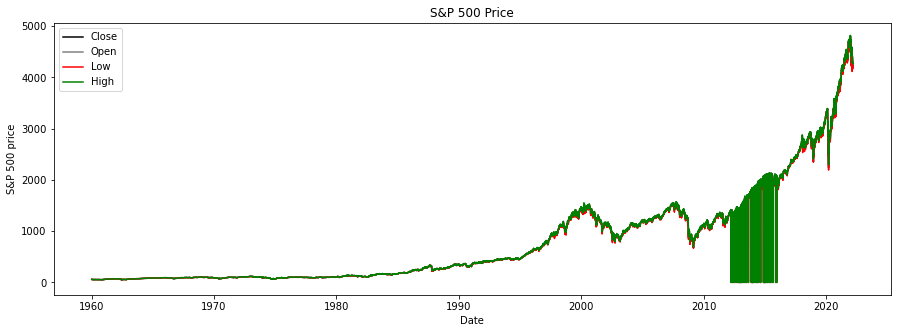

In [3]:
# show the graph
plt.figure(figsize=(15, 5));
plt.plot(price.Date, price.Close.values, color='black', label='Close')
plt.plot(price.Date, price.Open.values, color='grey', label='Open')
plt.plot(price.Date, price.Low.values, color='red', label='Low')
plt.plot(price.Date, price.High.values, color='green', label='High')
plt.title('S&P 500 Price')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
plt.show()

### We use Open and Close data to train the model

In [4]:
dataset = price[['Open' , 'Close']].values
dataset_original = dataset
dataset

array([[  59.91    ,   59.91    ],
       [  60.389999,   60.389999],
       [  60.130001,   60.130001],
       ...,
       [4223.1     , 4277.88    ],
       [4252.55    , 4259.52    ],
       [4279.5     , 4204.31    ]])

In [5]:
# extract the timestamp
date_data = price[['Date']].values
date_data

array([['1960-01-04T00:00:00.000000000'],
       ['1960-01-05T00:00:00.000000000'],
       ['1960-01-06T00:00:00.000000000'],
       ...,
       ['2022-03-09T00:00:00.000000000'],
       ['2022-03-10T00:00:00.000000000'],
       ['2022-03-11T00:00:00.000000000']], dtype='datetime64[ns]')

In [6]:
# scale the data by using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.01246953, 0.00162509],
       [0.01256944, 0.00172626],
       [0.01251532, 0.00167146],
       ...,
       [0.87898662, 0.8906744 ],
       [0.88511628, 0.88680454],
       [0.89072559, 0.87516757]])

In [7]:
# number of timepoints and features
n_rows, n_cols = dataset.shape
(n_rows, n_cols)

(15689, 2)

In [8]:
# general settings
# the number of expected features in the input x is 2
input_size = 2
# output_size = 4 as we want to predict the next one, two, three, and four trading data 
output_size = 4
# sequence length is 180, for the sliding sampling window
window_size = 180

In [9]:
# Creating a data structure with 180 timesteps and 4 output
X_full = []
Y_full = []
date_full = []
for i in range( n_rows - window_size - output_size +1):
    X_full.append(dataset[i:i+window_size, ])
    Y_full.append(dataset[i+window_size: i+ window_size + output_size, 0])
    date_full.append(date_data[i+window_size])
    
X_full, Y_full, date_full = np.array(X_full), np.array(Y_full), np.array(date_full)
Y_full = np.reshape(Y_full, (Y_full.shape[0], 1, Y_full.shape[1]))

In [10]:
X_train = []; Y_train = []; date_train = []
X_test = []; Y_test = []; date_test = []
for i in range(X_full.shape[0]):
    if(i  %  253 >= 200):
        X_test.append(X_full[i])
        Y_test.append(Y_full[i])
        date_test.append(date_full[i])
    else:
        X_train.append(X_full[i])
        Y_train.append(Y_full[i])
        date_train.append(date_full[i])
X_train, Y_train, date_train = np.array(X_train), np.array(Y_train), np.array(date_train)          
X_test, Y_test, date_test = np.array(X_test), np.array(Y_test), np.array(date_test)      

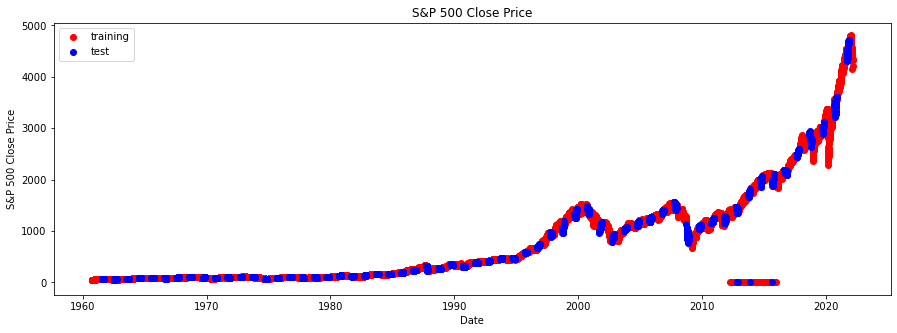

In [11]:
# Visualizing training dataset and test dataset
out_temp = np.concatenate((Y_train[:, 0, [0]], 
                           Y_train[:, 0, [0]]), axis=1)
price_train = scaler.inverse_transform(out_temp)[:, [0]]
price_val = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate((Y_test[:, 0, [0]], 
                           Y_test[:, 0, [0]]), axis=1)
price_test = scaler.inverse_transform(out_temp)[:, [0]]

plt.figure(figsize=(15, 5));
plt.plot(date_train, price_train[:,0], color = 'red', label = 'training', marker= 'o', linestyle='None')
plt.plot(date_test, price_test[:,0], color = 'blue', label = 'test', marker= 'o', linestyle='None')
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

## Design and develop a recurrent neural network (RNN) in Python.

In [12]:
class RNN (nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(RNN, self).__init__()
        # Define parameters
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Define layers
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        # Initialize hidden state for the first input
        hidden = self.init_hidden(batch_size)
        # Transport the input and hidden state into the RNN and get output
        out, hidden = self.rnn(x, hidden)
        # Reshape output in order to be used for fully connected layer
        out = self.fc(out)
        # Return final output
        return out[:, -1, :], hidden

    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden

In [13]:
# Other parameters for the RNN model
hidden_size = 16
n_layers = 1
learning_rate = 0.001
rnn_1 = RNN(input_size, output_size, hidden_size, n_layers)
optimizer = torch.optim.Adam(rnn_1.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [14]:
# The RNN model structure
rnn_1

RNN(
  (rnn): RNN(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

In [15]:
# Display parameters in the model
for name, param in rnn_1.named_parameters():
    print(name, param.data.shape)

rnn.weight_ih_l0 torch.Size([16, 2])
rnn.weight_hh_l0 torch.Size([16, 16])
rnn.bias_ih_l0 torch.Size([16])
rnn.bias_hh_l0 torch.Size([16])
fc.weight torch.Size([4, 16])
fc.bias torch.Size([4])


## Train RNN on Training Set (S&P500 data) then test to ensure it functions correctly when predicting the next one, two, three, and four trading data (close price).

In [16]:
loss_all_1 = []
for epoch in range(200):
    # make training sets in torch
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(Y_train).float())
    # set zero gradients
    optimizer.zero_grad()
    # forward pass
    output, hidden = rnn_1(inputs) 
    # calculate loss
    loss = criterion(output.reshape(-1), labels.view(-1))
    loss_all_1 += [loss.item()]
    # Backward pass
    loss.backward(retain_graph=True)
    # print loss
    if (epoch % 10 == 0 ):
        print("Epoch ", epoch, "MSE: ", loss.item())
    # Update parameters
    optimizer.step()        

Epoch  0 MSE:  0.08388754725456238
Epoch  10 MSE:  0.05697259679436684
Epoch  20 MSE:  0.03948923572897911
Epoch  30 MSE:  0.028663495555520058
Epoch  40 MSE:  0.02223918028175831
Epoch  50 MSE:  0.01613563857972622
Epoch  60 MSE:  0.009851097129285336
Epoch  70 MSE:  0.0059883976355195045
Epoch  80 MSE:  0.0034679400268942118
Epoch  90 MSE:  0.002357902005314827
Epoch  100 MSE:  0.0019256494706496596
Epoch  110 MSE:  0.001700820168480277
Epoch  120 MSE:  0.0015275311889126897
Epoch  130 MSE:  0.0013806350762024522
Epoch  140 MSE:  0.0012587627861648798
Epoch  150 MSE:  0.001157874707132578
Epoch  160 MSE:  0.0010730096837505698
Epoch  170 MSE:  0.001000514137558639
Epoch  180 MSE:  0.0009379901457577944
Epoch  190 MSE:  0.0008837280911393464


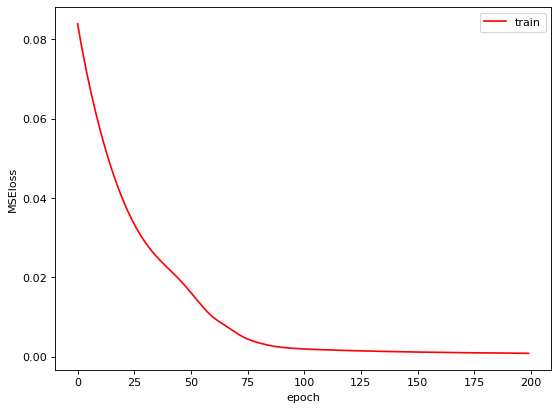

In [17]:
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(loss_all_1), 'r', label = 'train')
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.legend()

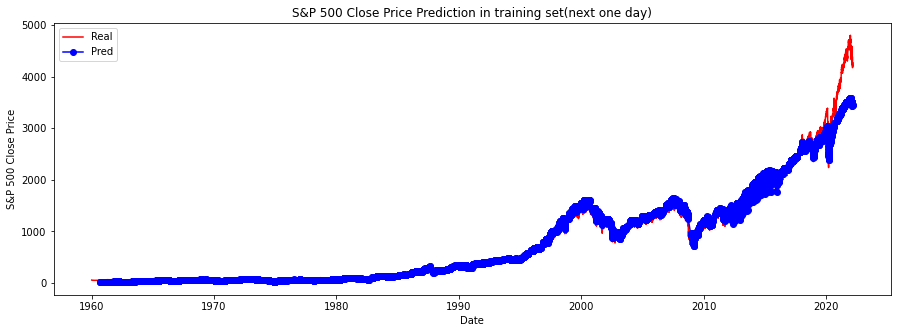

In [18]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [0]], 
                           output.detach().numpy()[:, [0]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

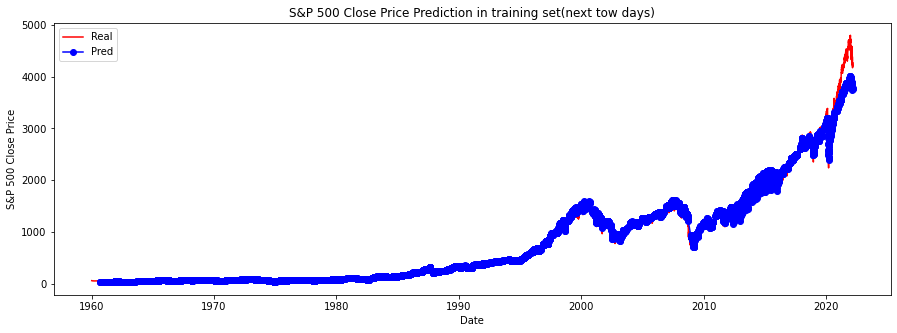

In [19]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [1]], 
                           output.detach().numpy()[:, [1]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next tow days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

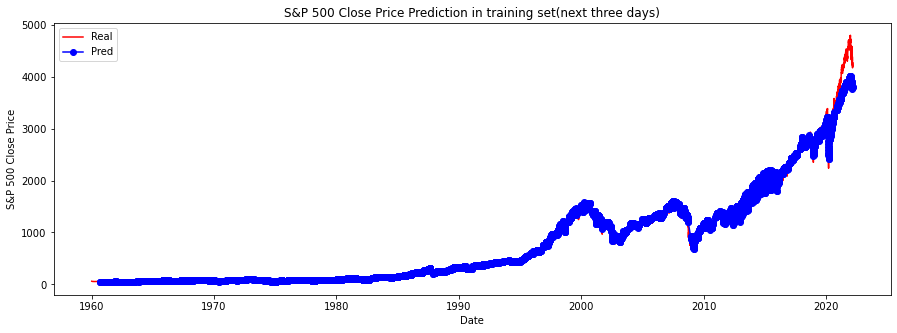

In [20]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [2]], 
                           output.detach().numpy()[:, [2]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

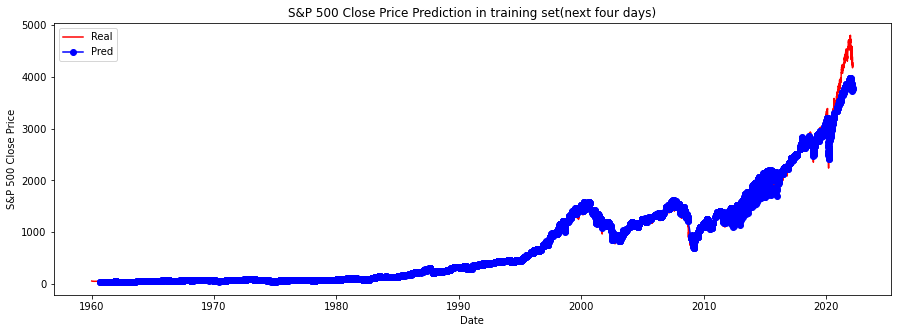

In [21]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [3]], 
                           output.detach().numpy()[:, [3]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

From the MSE loss figure, the loss for the training set keep decrease. Through the prediction plot we can see that at the end of the figure, there is a little under-fitting.

## Test RNN accuracy in predicting the next one, two, three, and four datapoints in the dataset from 1 Jan 1980 through the present day.

### Accuracy will be computed in terms of error defined as prediction_error := |predicted_price - actual_price| / actual_price.

In [22]:
# compute prediction_error := (predicted_price - actual_price) / actual_price 
def prediction_error(pred,target):
    error = abs(pred - target)/target
    return error

In [23]:
# store mean error for the training dataset
mean_train = []
# store mean error for the test dataset
mean_test = []

### Training dataset prediction_error as a function of timestamp.

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


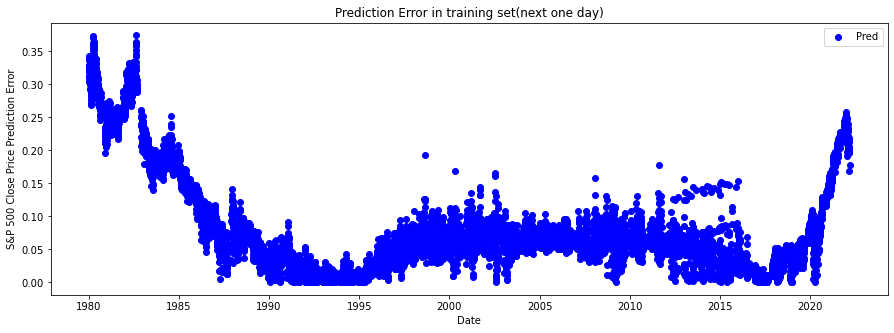

In [24]:
out_temp = np.concatenate((output.detach().numpy()[:, [0]], 
                           output.detach().numpy()[:, [0]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 0], Y_train[:, :, 0]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_train.append(np.mean(error_partial))

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


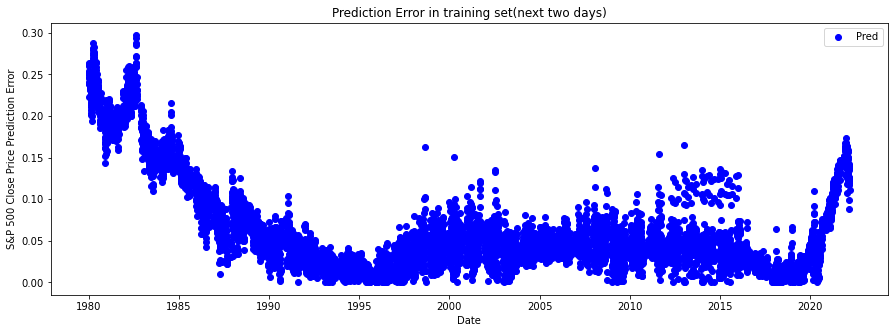

In [25]:
out_temp = np.concatenate((output.detach().numpy()[:, [1]], 
                           output.detach().numpy()[:, [1]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 1], Y_train[:, :, 1]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_train.append(np.mean(error_partial))

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


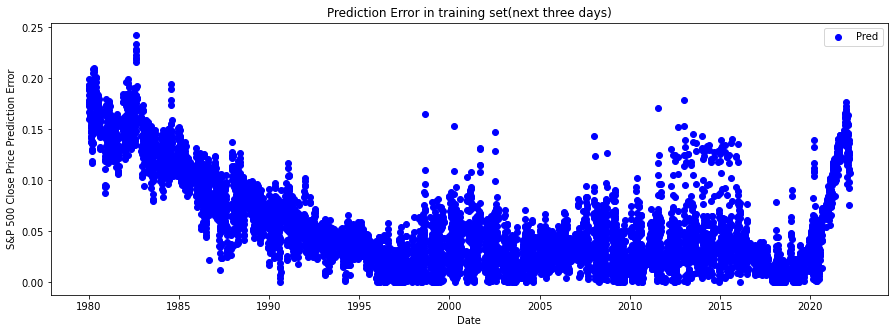

In [26]:
out_temp = np.concatenate((output.detach().numpy()[:, [2]], 
                           output.detach().numpy()[:, [2]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 2], Y_train[:, :, 2]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_train.append(np.mean(error_partial))

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


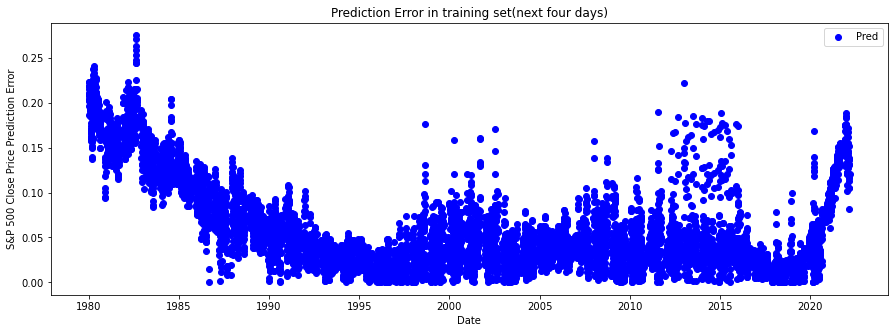

In [27]:
out_temp = np.concatenate((output.detach().numpy()[:, [3]], 
                           output.detach().numpy()[:, [3]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 3], Y_train[:, :, 3]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_train.append(np.mean(error_partial))

### Testing dataset prediction_error as a function of timestamp.

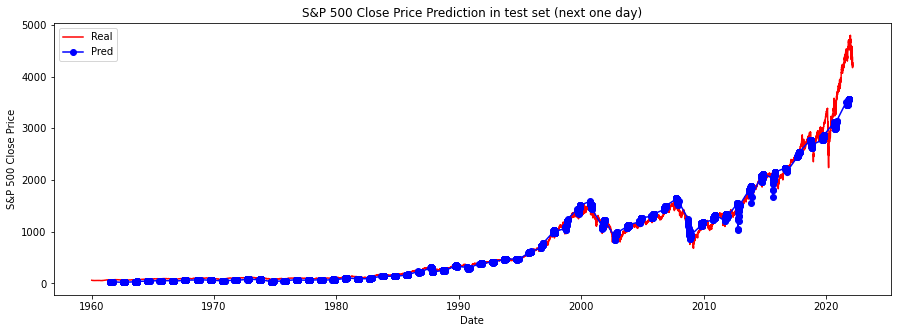

In [28]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_1(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [0]], 
                           output_test.detach().numpy()[:, [0]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


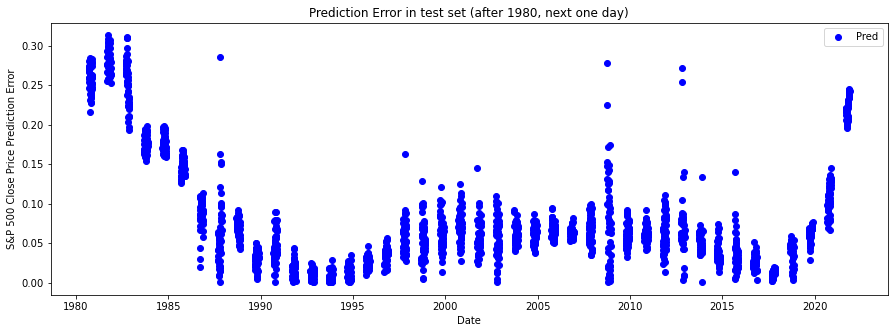

In [29]:
out_temp = np.concatenate( (Y_test[:, :, 0], Y_test[:, :, 0]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_test.append(np.mean(error_partial))

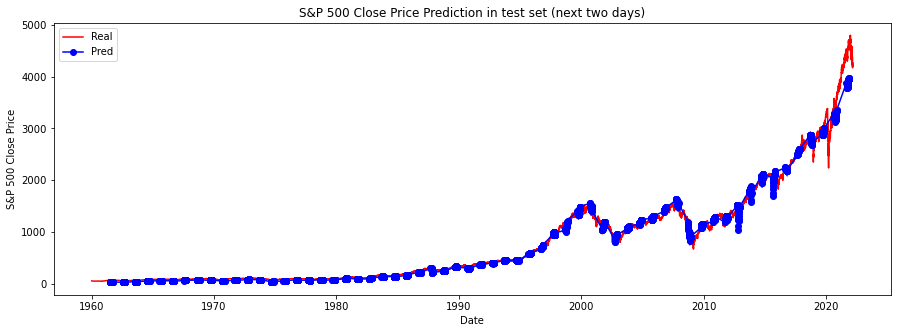

In [30]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_1(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [1]], 
                           output_test.detach().numpy()[:, [1]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


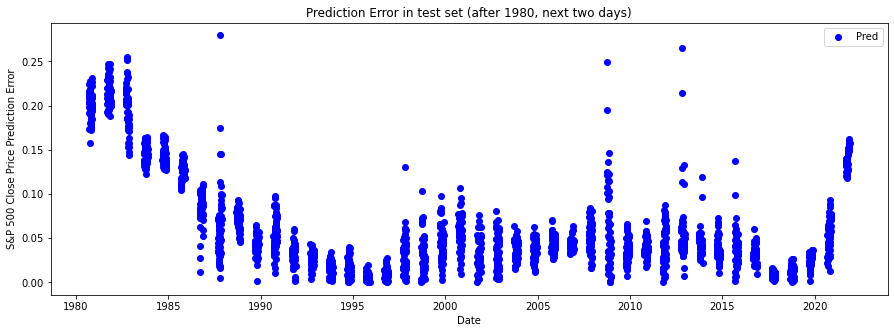

In [31]:
out_temp = np.concatenate( (Y_test[:, :, 1], Y_test[:, :, 1]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_test.append(np.mean(error_partial))

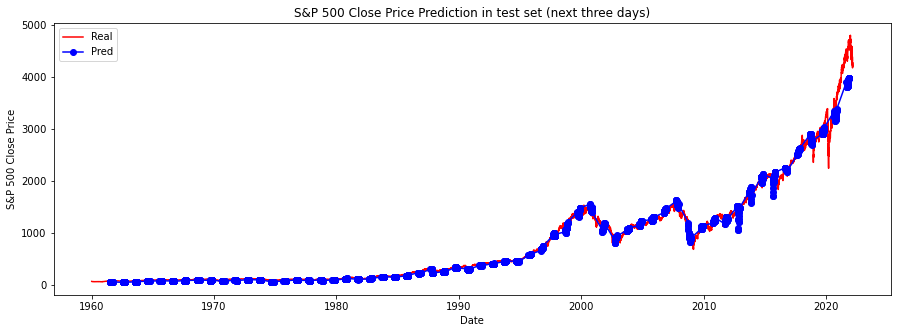

In [32]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_1(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [2]], 
                           output_test.detach().numpy()[:, [2]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


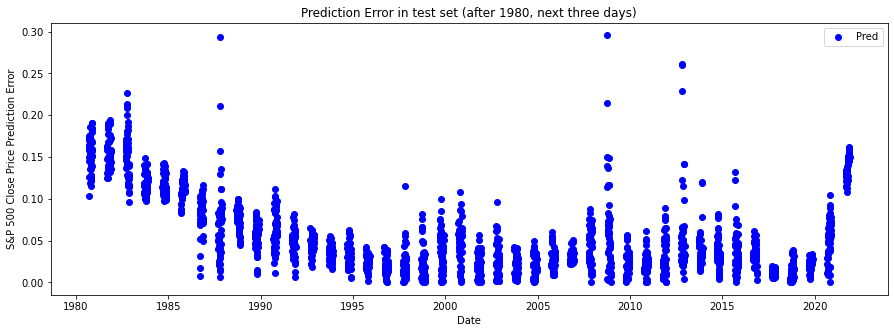

In [33]:
out_temp = np.concatenate( (Y_test[:, :, 2], Y_test[:, :, 2]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_test.append(np.mean(error_partial))

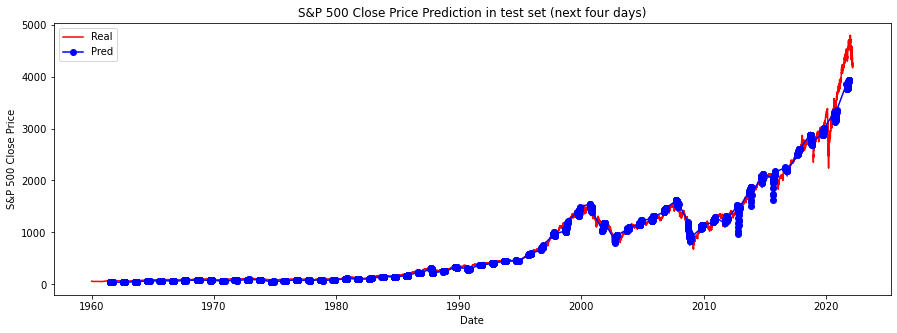

In [34]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_1(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [3]], 
                           output_test.detach().numpy()[:, [3]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


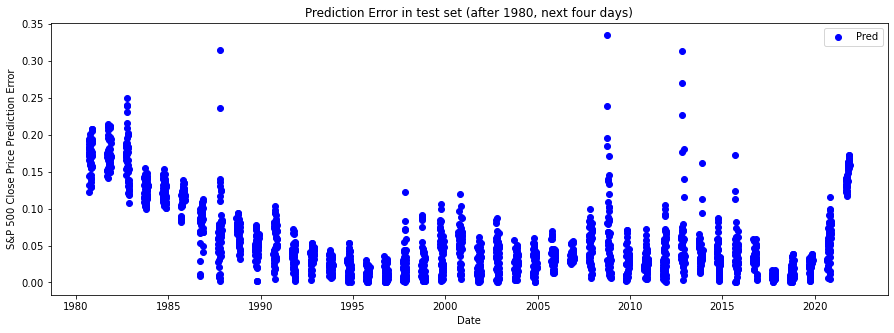

In [35]:
out_temp = np.concatenate( (Y_test[:, :, 3], Y_test[:, :, 3]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_test.append(np.mean(error_partial))

## Optimize RNN performance to yield maximum achievable accuracy

In [36]:
# construct data structure with validation set 
X_train = []; Y_train = []; date_train = []
X_val = []; Y_val = []; date_val = []
X_test = []; Y_test = []; date_test = []
for i in range(X_full.shape[0]):
    if(i  %  253 >= 200):
        X_test.append(X_full[i])
        Y_test.append(Y_full[i])
        date_test.append(date_full[i])
    elif (i % 253 < 160):
        X_train.append(X_full[i])
        Y_train.append(Y_full[i])
        date_train.append(date_full[i])
    else:
        X_val.append(X_full[i])
        Y_val.append(Y_full[i])
        date_val.append(date_full[i])
X_train, Y_train, date_train = np.array(X_train), np.array(Y_train), np.array(date_train) 
X_val, Y_val, date_val = np.array(X_val), np.array(Y_val), np.array(date_val) 
X_test, Y_test, date_test = np.array(X_test), np.array(Y_test), np.array(date_test)

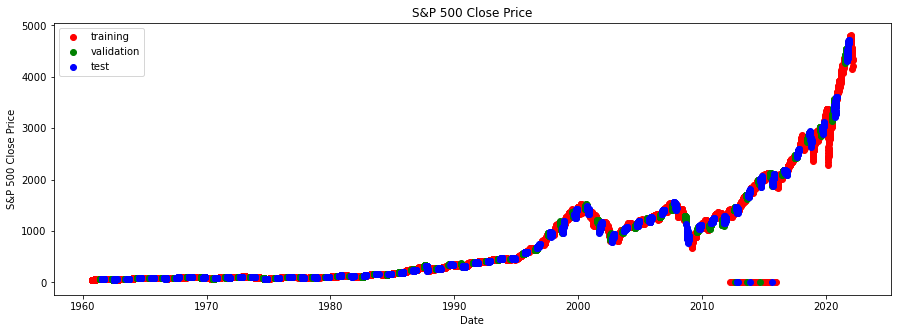

In [37]:
# Visualizing training dataset and test dataset and validation dataset
out_temp = np.concatenate((Y_train[:, 0, [0]], 
                           Y_train[:, 0, [0]]), axis=1)
price_train = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate((Y_val[:, 0, [0]], 
                           Y_val[:, 0, [0]]), axis=1)
price_val = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate((Y_test[:, 0, [0]], 
                           Y_test[:, 0, [0]]), axis=1)
price_test = scaler.inverse_transform(out_temp)[:, [0]]
# Visualising training dataset and test dataset
plt.figure(figsize=(15, 5));
plt.plot(date_train, price_train[:,0], color = 'red', label = 'training', marker= 'o', linestyle='None')
plt.plot(date_val, price_val[:,0], color = 'green', label = 'validation', marker= 'o', linestyle='None')
plt.plot(date_test, price_test[:,0], color = 'blue', label = 'test', marker= 'o', linestyle='None')
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

In [38]:
# parameters for the RNN model
hidden_size = 32
n_layers = 2
learning_rate = 0.005
rnn_2 = RNN(input_size, output_size, hidden_size, n_layers)
optimizer = torch.optim.Adam(rnn_2.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [39]:
# The RNN model structure
rnn_2

RNN(
  (rnn): RNN(2, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

In [40]:
# Display parameters in the model
for name, param in rnn_2.named_parameters():
    print(name, param.data.shape)

rnn.weight_ih_l0 torch.Size([32, 2])
rnn.weight_hh_l0 torch.Size([32, 32])
rnn.bias_ih_l0 torch.Size([32])
rnn.bias_hh_l0 torch.Size([32])
rnn.weight_ih_l1 torch.Size([32, 32])
rnn.weight_hh_l1 torch.Size([32, 32])
rnn.bias_ih_l1 torch.Size([32])
rnn.bias_hh_l1 torch.Size([32])
fc.weight torch.Size([4, 32])
fc.bias torch.Size([4])


In [41]:
# begin training
loss_all_2 = []
loss_all_2_val = []
for epoch in range(70):
    # change training sets into torch tensors
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(Y_train).float())

    # set zero gradients
    optimizer.zero_grad()

    # set forward pass
    output, hidden = rnn_2(inputs)

    # calculate loss
    loss = criterion(output.reshape(-1), labels.view(-1))
    loss_all_2 += [loss.item()]

    # backward pass
    loss.backward(retain_graph=True)

    # loss for validation set
    inputs_val = torch.from_numpy(X_val).float()
    labels_val = torch.from_numpy(Y_val).float()
    output_val, hidden_val = rnn_2(inputs_val)
    loss_val = criterion(output_val.reshape(-1), labels_val.view(-1))
    loss_all_2_val += [loss_val.item()]

    # show loss
    if epoch % 10 == 0:
        print('Epoch: %d, Loss: %.5f, Loss_val: %.5f' % (epoch, loss.item(), loss_val.item()))

    # update weights
    optimizer.step()

Epoch: 0, Loss: 0.08414, Loss_val: 0.08467
Epoch: 10, Loss: 0.01270, Loss_val: 0.01238
Epoch: 20, Loss: 0.00213, Loss_val: 0.00195
Epoch: 30, Loss: 0.00136, Loss_val: 0.00117
Epoch: 40, Loss: 0.00090, Loss_val: 0.00064
Epoch: 50, Loss: 0.00063, Loss_val: 0.00039
Epoch: 60, Loss: 0.00061, Loss_val: 0.00037


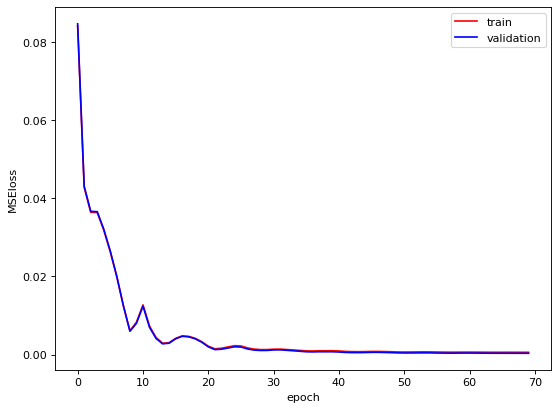

In [42]:
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(loss_all_2), 'r', label = 'train')
plt.plot(np.array(loss_all_2_val), 'b', label = 'validation')
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.legend()

### Training dataset prediction_error as a function of timestamp(Optimize).

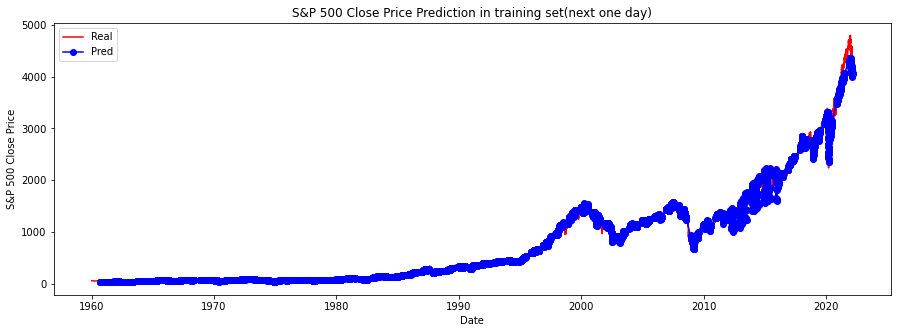

In [43]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [0]], 
                           output.detach().numpy()[:, [0]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


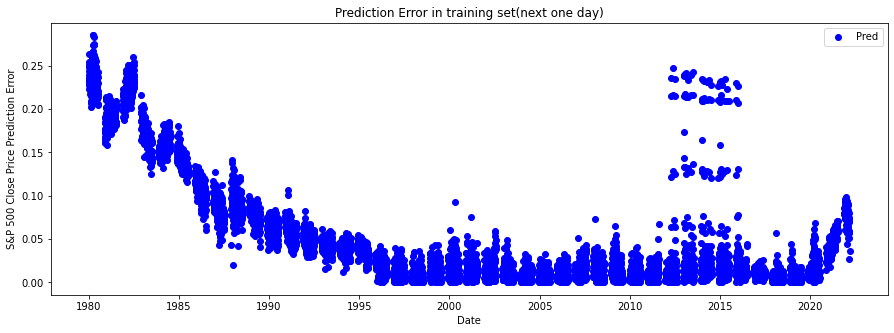

In [44]:
out_temp = np.concatenate((output.detach().numpy()[:, [0]], 
                           output.detach().numpy()[:, [0]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 0], Y_train[:, :, 0]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_train.append(np.mean(error_partial))

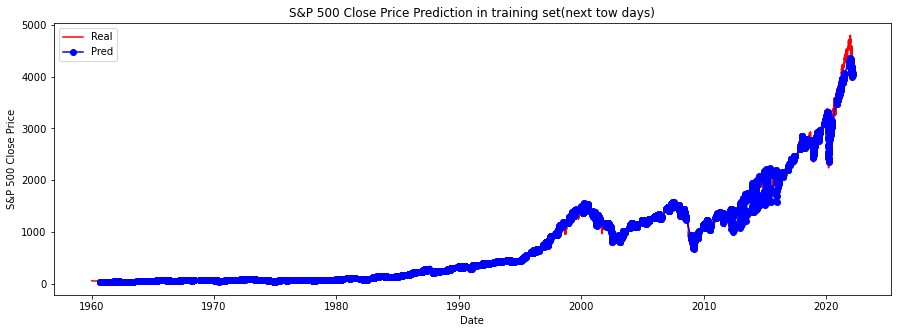

In [45]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [1]], 
                           output.detach().numpy()[:, [1]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next tow days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


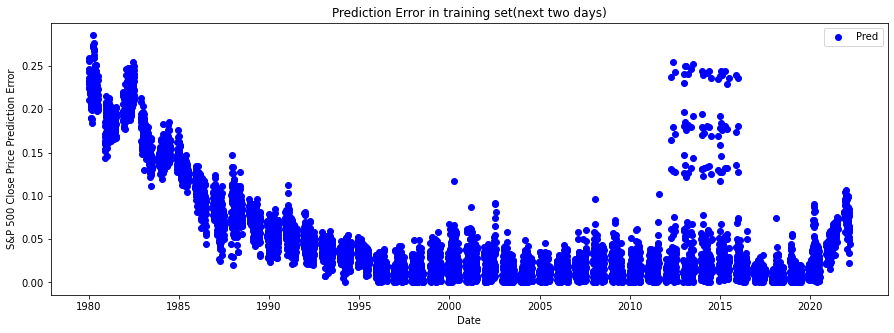

In [46]:
out_temp = np.concatenate((output.detach().numpy()[:, [1]], 
                           output.detach().numpy()[:, [1]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 1], Y_train[:, :, 1]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_train.append(np.mean(error_partial))

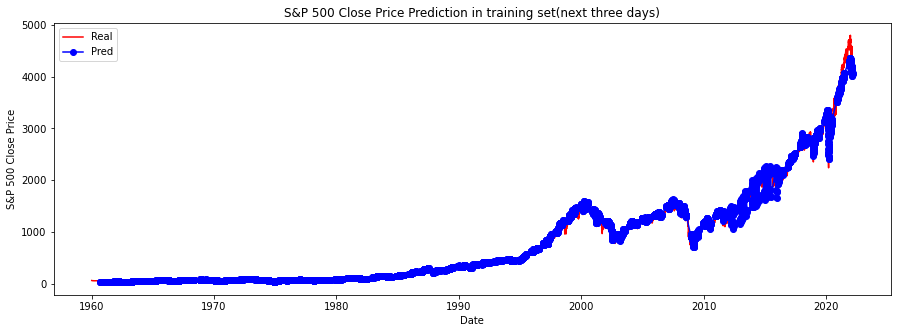

In [47]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [2]], 
                           output.detach().numpy()[:, [2]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


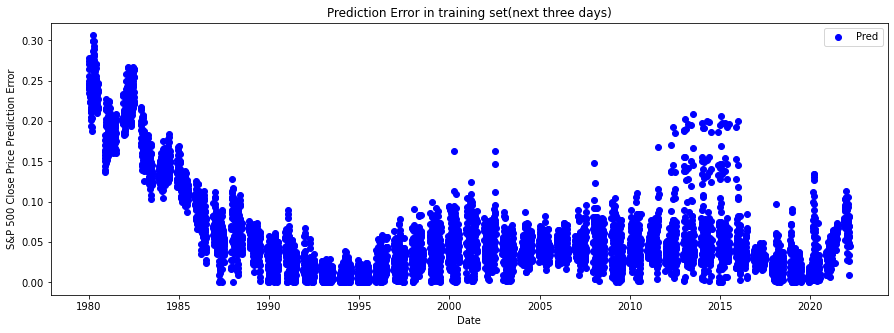

In [48]:
out_temp = np.concatenate((output.detach().numpy()[:, [2]], 
                           output.detach().numpy()[:, [2]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 2], Y_train[:, :, 2]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_train.append(np.mean(error_partial))

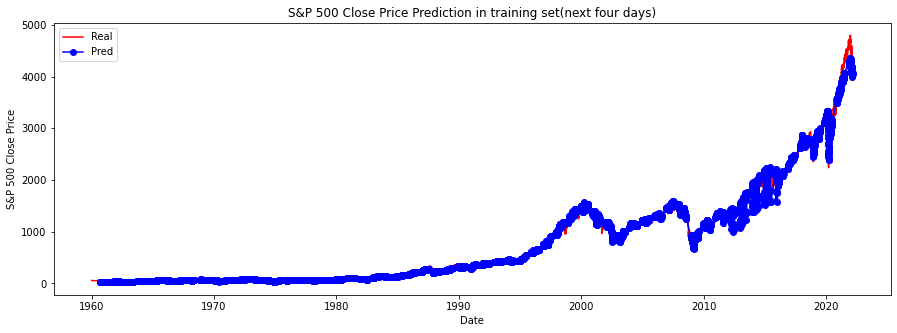

In [49]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [3]], 
                           output.detach().numpy()[:, [3]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


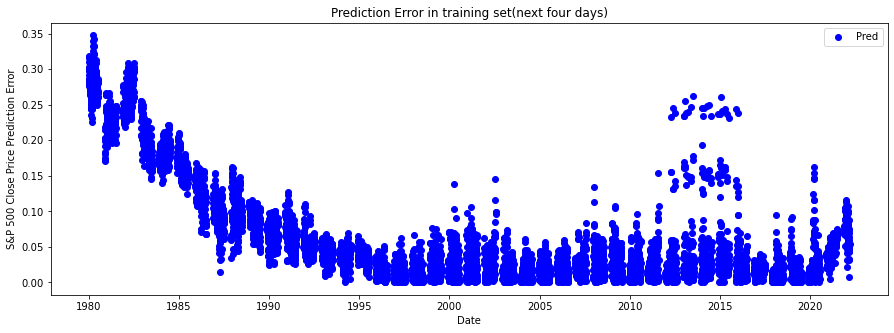

In [50]:
out_temp = np.concatenate((output.detach().numpy()[:, [3]], 
                           output.detach().numpy()[:, [3]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 3], Y_train[:, :, 3]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_train.append(np.mean(error_partial))

### Testing dataset prediction_error as a function of timestamp(Optimize).

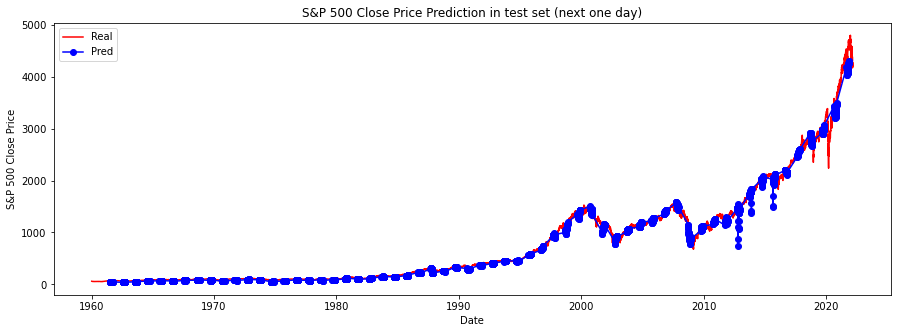

In [51]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_2(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [0]], 
                           output_test.detach().numpy()[:, [0]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


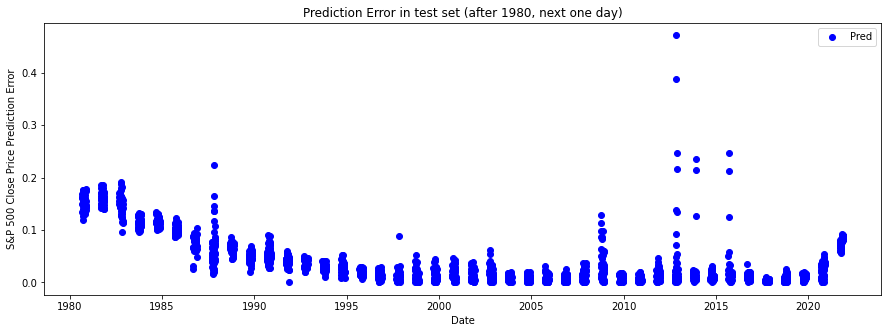

In [52]:
out_temp = np.concatenate( (Y_test[:, :, 0], Y_test[:, :, 0]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_test.append(np.mean(error_partial))

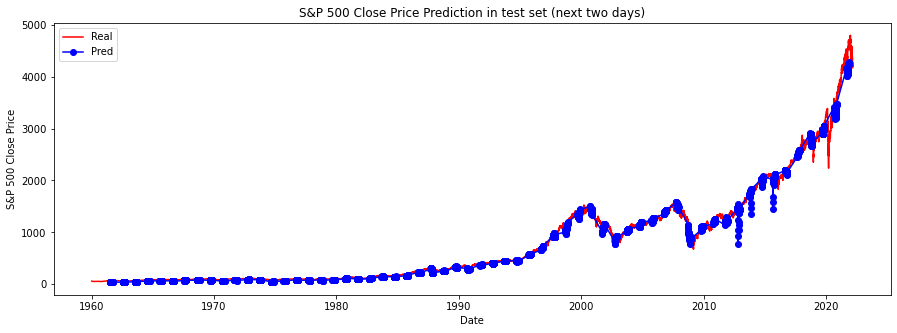

In [53]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_2(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [1]], 
                           output_test.detach().numpy()[:, [1]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


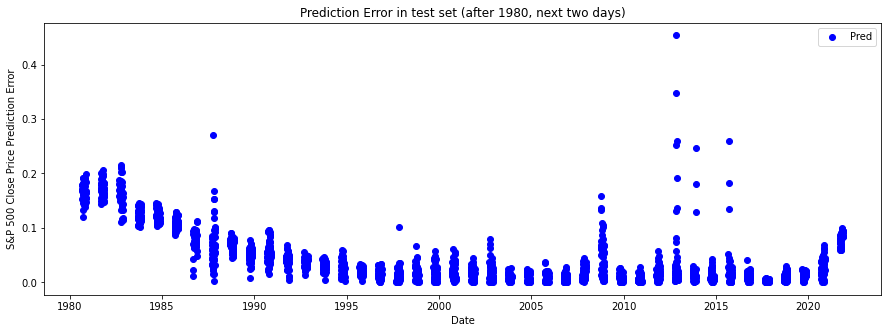

In [54]:
out_temp = np.concatenate( (Y_test[:, :, 1], Y_test[:, :, 1]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_test.append(np.mean(error_partial))

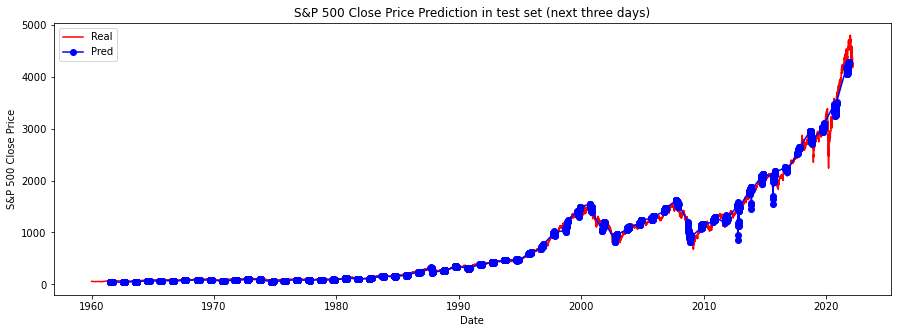

In [55]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_2(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [2]], 
                           output_test.detach().numpy()[:, [2]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


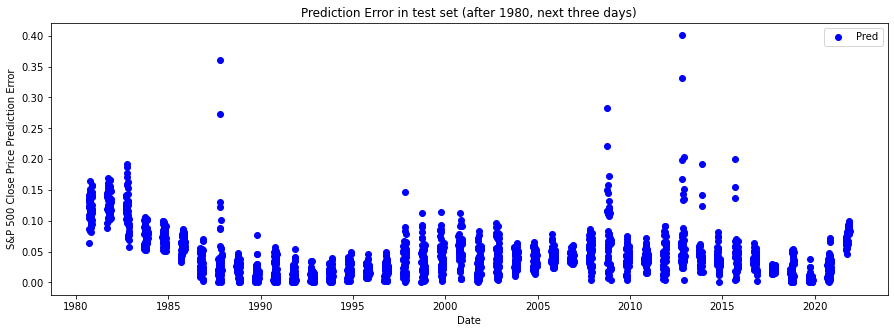

In [56]:
out_temp = np.concatenate( (Y_test[:, :, 2], Y_test[:, :, 2]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_test.append(np.mean(error_partial))

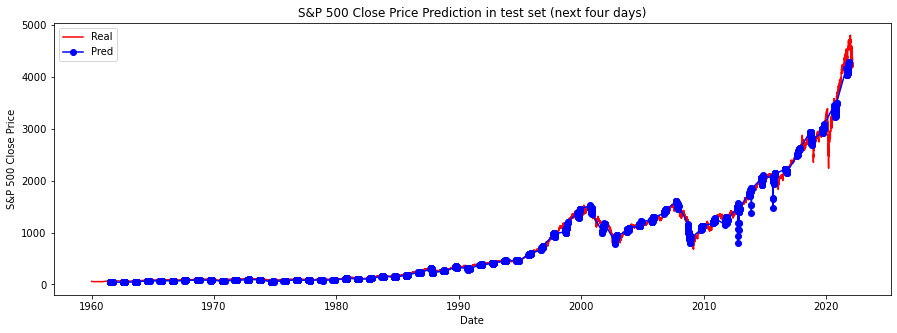

In [57]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_2(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [3]], 
                           output_test.detach().numpy()[:, [3]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(price.Date, dataset_original[:,1], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target


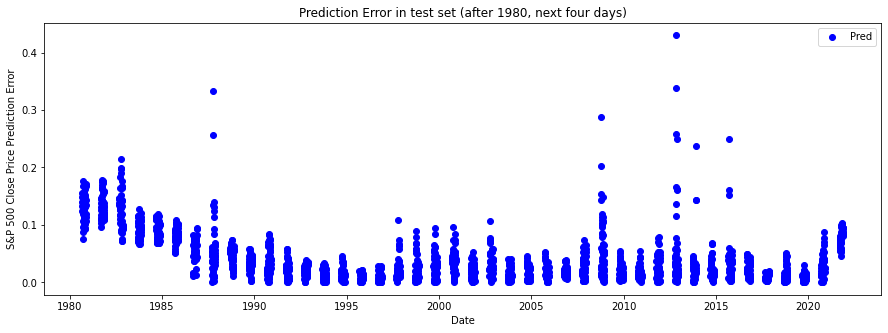

In [58]:
out_temp = np.concatenate( (Y_test[:, :, 3], Y_test[:, :, 3]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_test.append(np.mean(error_partial))

## Investigate the effect of Input Noise and Uncertainty

In [59]:
# standard deviation
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float64)
    #set seed for random numbers
    random.seed(1)
    for i in range(len(dataset)):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(window_size)), 18)
        dataset_noise[i] = dataset[i]    
        dataset_noise[i, index, 0] = dataset_noise[i, index, 0] + s
    return dataset_noise

In [60]:
#predict next day (idx = 0)
idx = 0
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in std:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_2(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(predicted_price_test,target_test)
    error_res_all.append(error.reshape(-1))

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encount

In [61]:
labels = date_test[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=std).T
error_df

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-07,0.299311,0.299314,0.299314,0.299331,0.299332,0.299356,0.299358,0.299422,0.298782
1961-07-10,0.281617,0.304978,0.357159,0.365033,0.310309,0.430847,0.107779,1.381079,0.249280
1961-07-11,0.296997,0.296381,0.292328,0.297251,0.288471,0.284508,0.297227,0.373690,0.311106
1961-07-12,0.294896,0.292319,0.297372,0.285804,0.298426,0.278272,0.315474,0.280785,0.016389
1961-07-13,0.290206,0.283500,0.271382,0.261911,0.382851,0.315350,0.333520,0.181481,0.448168
...,...,...,...,...,...,...,...,...,...
2021-11-15,0.090496,0.090508,0.090520,0.090492,0.090574,0.090440,0.090544,0.090265,0.090130
2021-11-16,0.086996,0.086995,0.086995,0.086994,0.086996,0.086997,0.087016,0.086995,0.086929
2021-11-17,0.089384,0.089384,0.089384,0.089384,0.089384,0.089384,0.089384,0.089384,0.089384
2021-11-18,0.087544,0.087541,0.087546,0.087538,0.087544,0.087540,0.087512,0.087666,0.087523


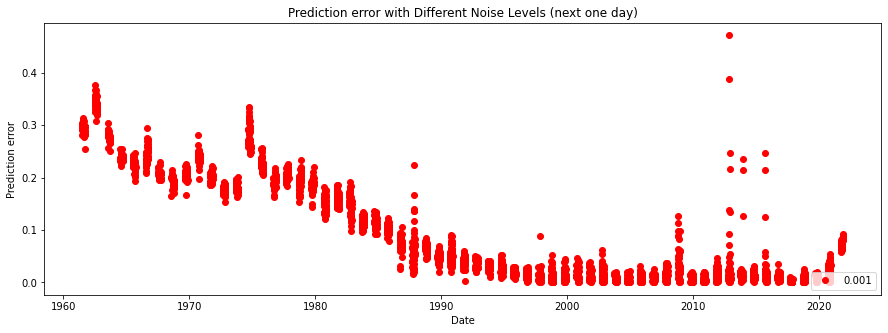

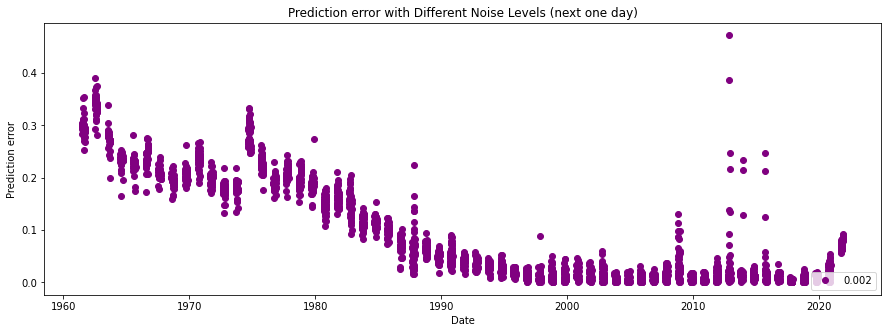

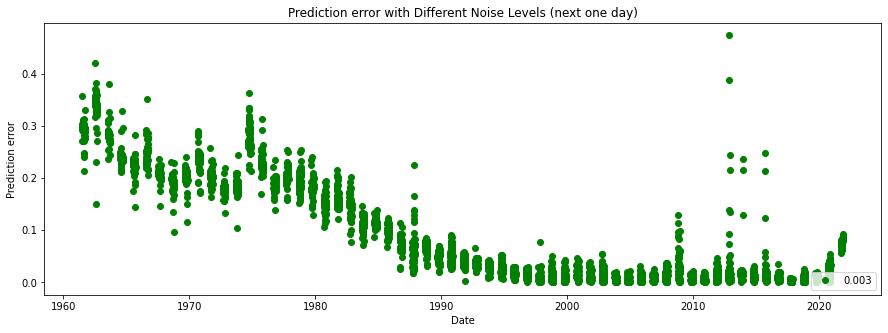

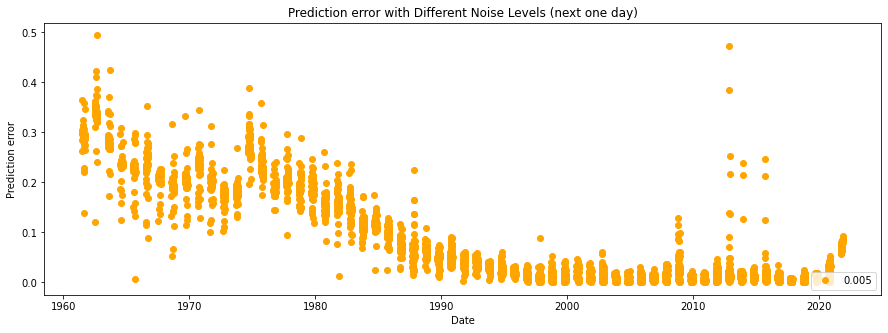

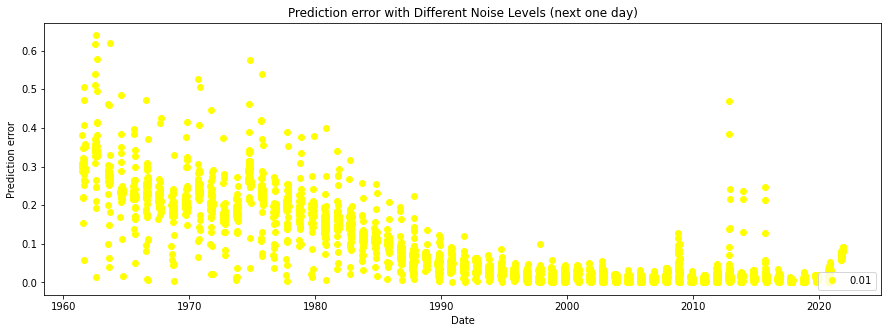

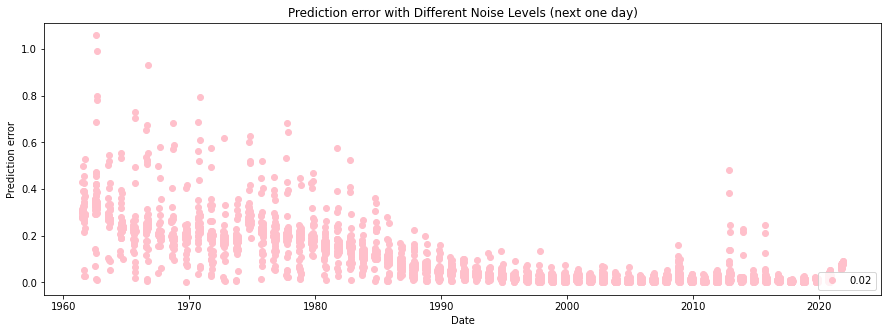

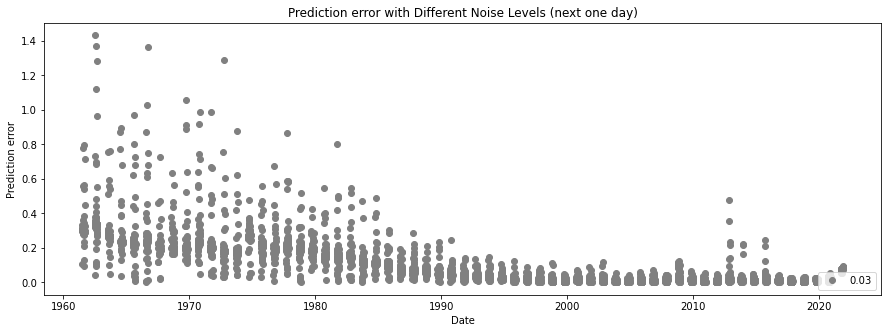

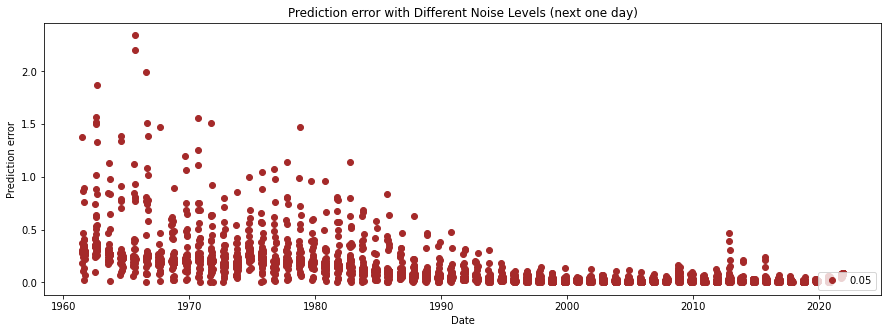

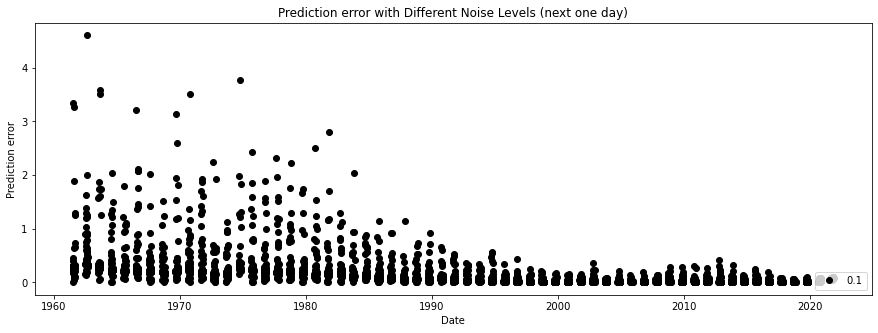

In [62]:
colors= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
for i in range(len(std)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_test, error_res_all[i], color=colors[i], lw=1, label = std[i], marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next one day)')
    plt.legend(loc="lower right")  
    plt.show()

In [63]:
#predict next two days (idx = 1)
idx = 1
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in std:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_2(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(predicted_price_test,target_test)
    error_res_all.append(error.reshape(-1))

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encount

In [64]:
temp = date_test + pd.Timedelta('1 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=std).T
error_df

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-08,0.323070,0.323000,0.323051,0.323038,0.323005,0.322973,0.323480,0.322782,0.321335
1961-07-11,0.320572,0.294683,0.300766,0.320136,0.306699,0.317172,0.774740,0.257501,0.814733
1961-07-12,0.317373,0.317318,0.317540,0.317843,0.318135,0.317576,0.316113,0.314563,0.330086
1961-07-13,0.314815,0.317330,0.313292,0.311120,0.309126,0.317513,0.310726,0.281197,0.361602
1961-07-14,0.344403,0.303118,0.291353,0.324231,0.780032,0.086023,0.467854,2.124642,1.885346
...,...,...,...,...,...,...,...,...,...
2021-11-16,0.092795,0.092828,0.092850,0.092691,0.092872,0.093170,0.092171,0.092589,0.091014
2021-11-17,0.095280,0.095280,0.095280,0.095279,0.095280,0.095277,0.095279,0.095276,0.095265
2021-11-18,0.093314,0.093314,0.093314,0.093314,0.093314,0.093314,0.093314,0.093314,0.093314
2021-11-19,0.093279,0.093280,0.093282,0.093282,0.093274,0.093272,0.093220,0.093334,0.093238


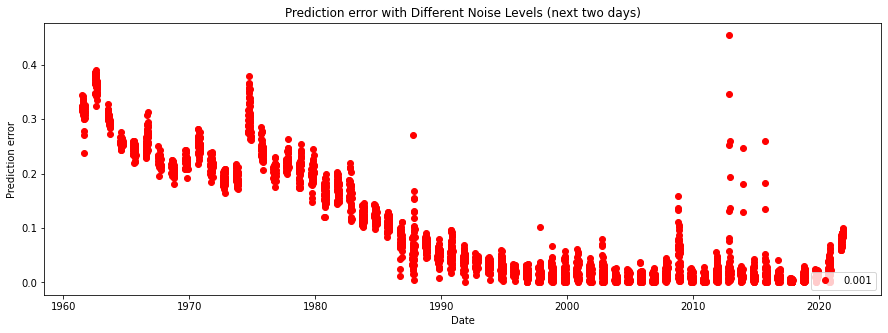

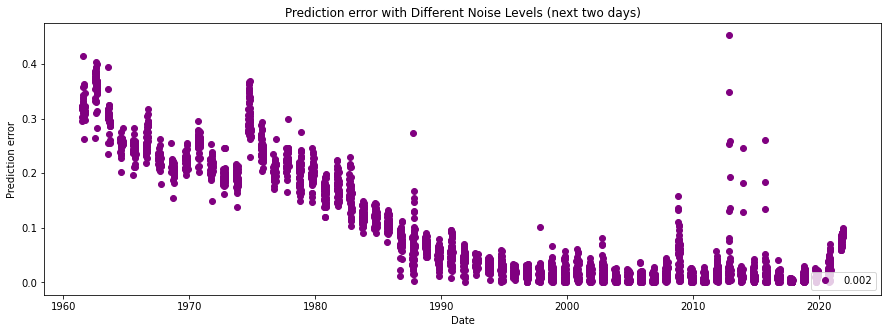

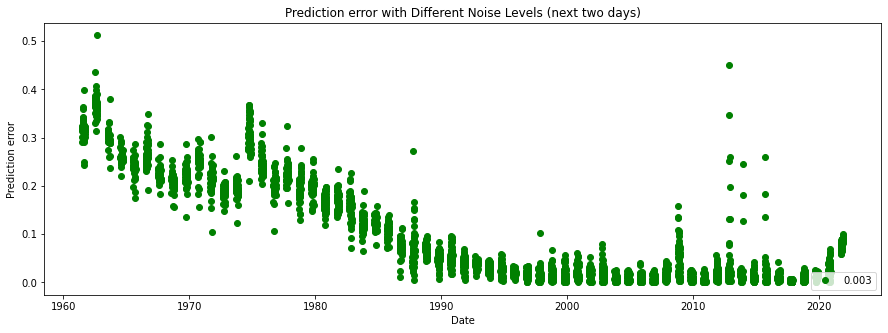

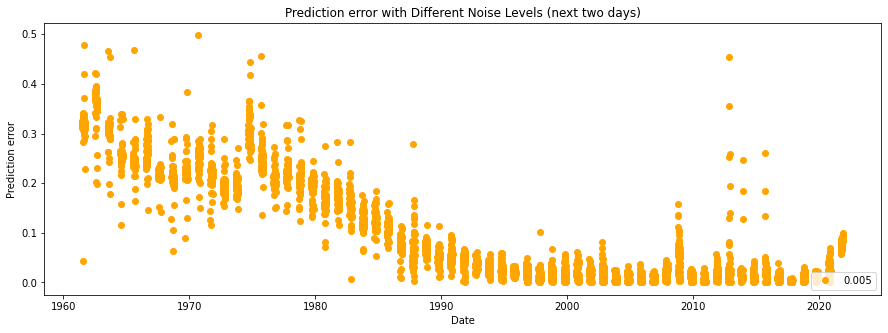

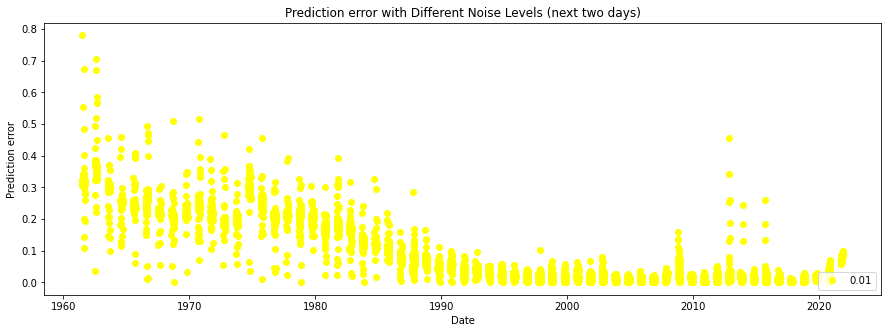

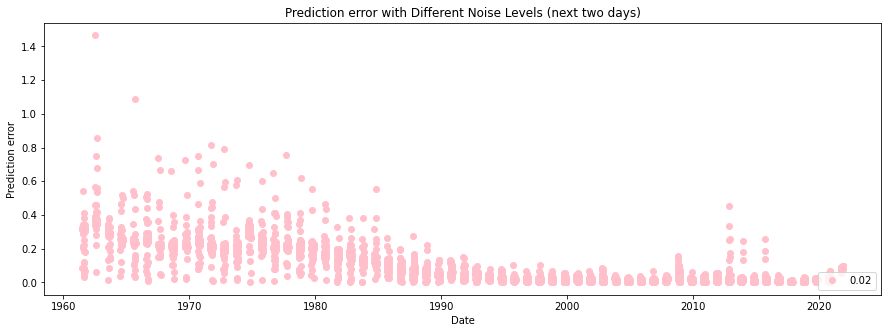

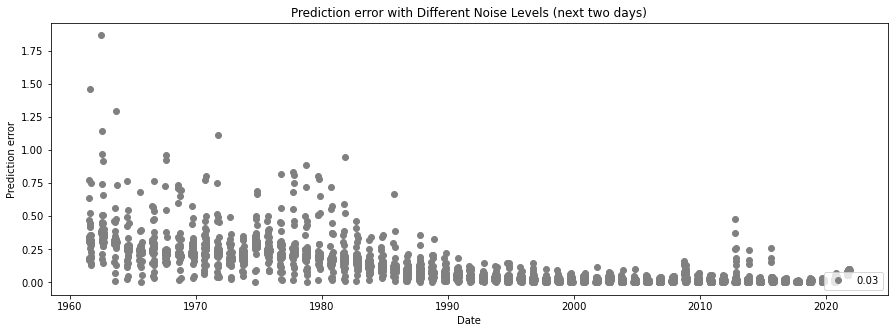

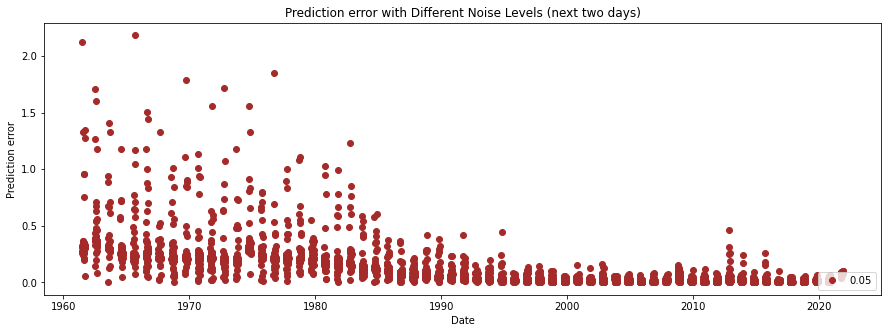

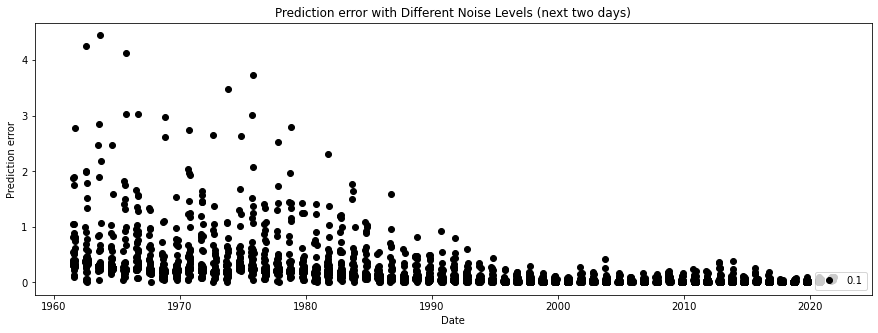

In [65]:
for i in range(len(std)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_test+ pd.Timedelta('1 day'), error_res_all[i], color=colors[i], lw=1, label = std[i], 
             marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next two days)')
    plt.legend(loc="lower right")  
    plt.show()

In [66]:
#predict next three days (idx = 2)
idx = 2
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in std:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_2(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(predicted_price_test,target_test)
    error_res_all.append(error.reshape(-1))

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encount

In [67]:
temp = date_test + pd.Timedelta('2 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=std).T
error_df

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-09,0.279225,0.279210,0.279211,0.279242,0.279416,0.278857,0.279046,0.279344,0.282995
1961-07-12,0.258072,0.281491,0.234571,0.252853,0.428924,0.466133,1.205213,0.636855,0.592301
1961-07-13,0.266439,0.264205,0.268172,0.261057,0.236942,0.258724,0.298561,0.227849,0.238634
1961-07-14,0.272913,0.275854,0.273708,0.274464,0.279872,0.286952,0.277999,0.306645,0.275733
1961-07-15,0.279107,0.281538,0.201697,0.313854,0.189615,0.187974,0.782269,0.889316,1.862716
...,...,...,...,...,...,...,...,...,...
2021-11-17,0.093180,0.093157,0.093231,0.093310,0.092967,0.092880,0.093458,0.094855,0.090198
2021-11-18,0.091755,0.091755,0.091754,0.091755,0.091754,0.091752,0.091759,0.091745,0.091771
2021-11-19,0.091655,0.091655,0.091655,0.091655,0.091655,0.091655,0.091655,0.091655,0.091655
2021-11-20,0.090479,0.090481,0.090479,0.090485,0.090500,0.090483,0.090443,0.090447,0.090354


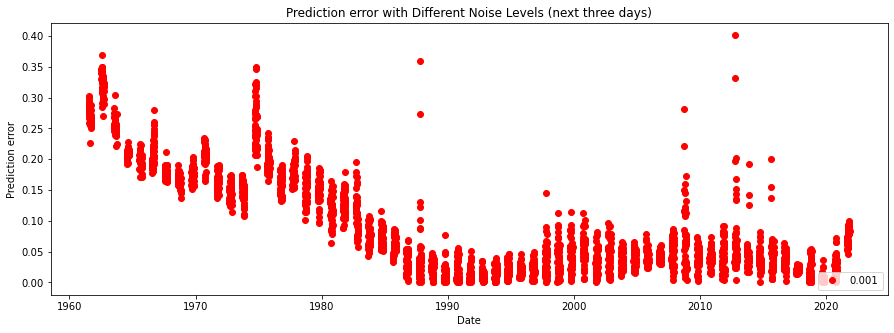

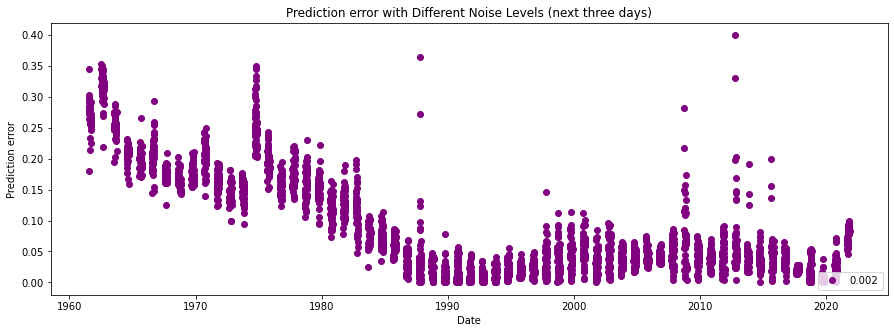

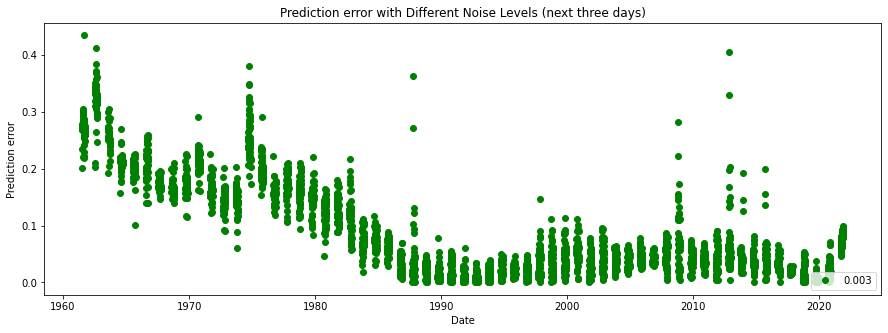

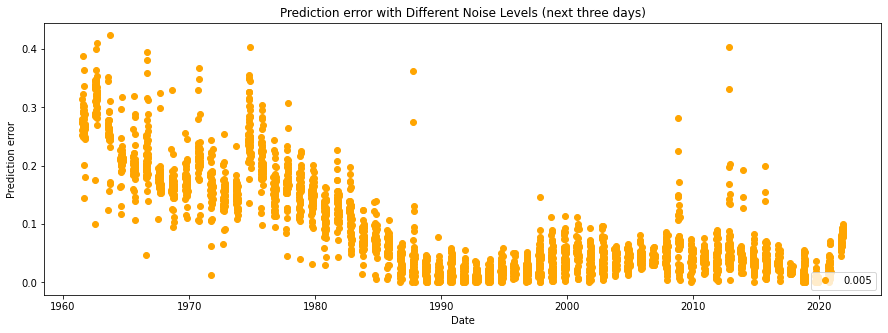

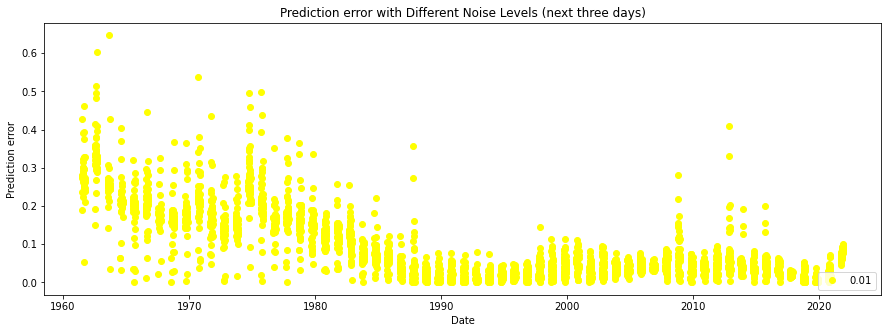

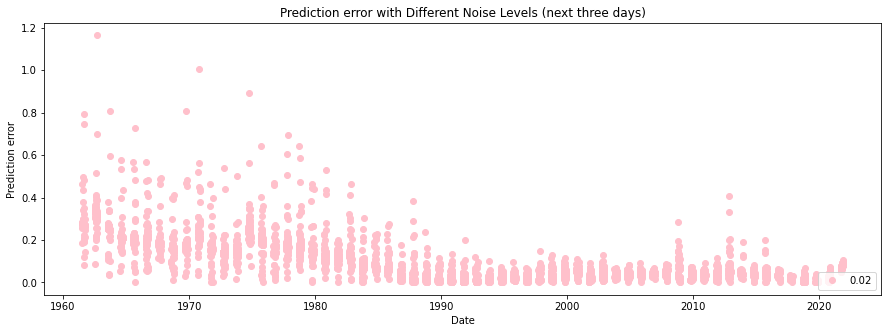

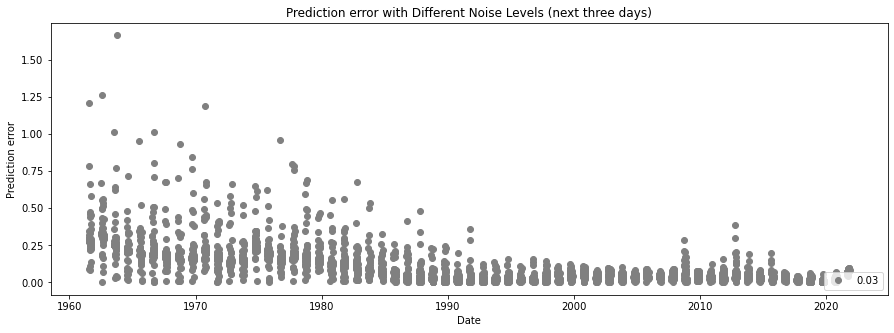

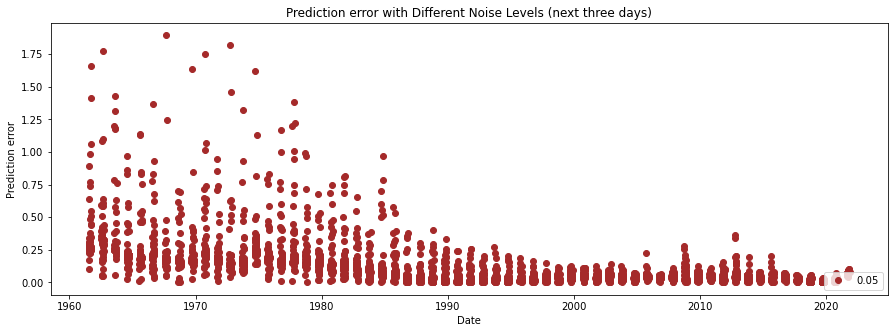

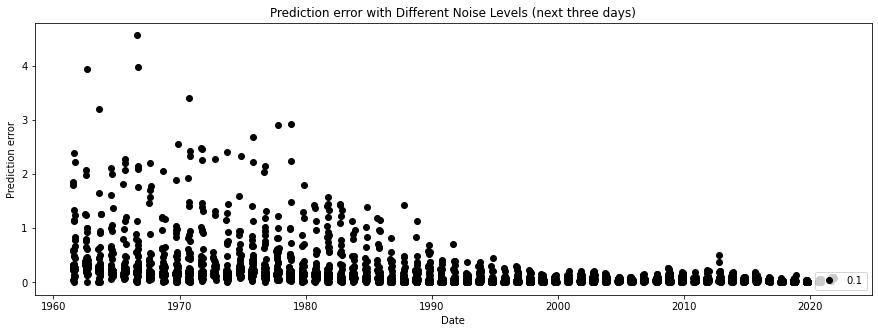

In [68]:
for i in range(len(std)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_test+ pd.Timedelta('2 day'), error_res_all[i], color=colors[i], lw=1, label = std[i], 
             marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next three days)')
    plt.legend(loc="lower right")  
    plt.show()

In [69]:
#predict next four days (idx = 3)
idx = 3
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in std:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_2(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(predicted_price_test,target_test)
    error_res_all.append(error.reshape(-1))

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encountered in true_divide
  error = abs(pred - target)/target
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_37153/1591607620.py:3: RuntimeWarning: divide by zero encount

In [70]:
temp = date_test + pd.Timedelta('3 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=std).T
error_df

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-10,0.253621,0.253629,0.253636,0.253653,0.253463,0.253460,0.254868,0.253256,0.256039
1961-07-13,0.257040,0.227237,0.232936,0.251418,0.199504,0.172682,0.348941,1.038906,0.255289
1961-07-14,0.250665,0.249945,0.253504,0.252169,0.253752,0.227794,0.277233,0.353477,0.382667
1961-07-15,0.245622,0.247677,0.248537,0.248433,0.253310,0.226355,0.232657,0.269089,0.223477
1961-07-16,0.238359,0.205504,0.237485,0.288733,0.418667,0.158636,0.053790,1.397107,0.000156
...,...,...,...,...,...,...,...,...,...
2021-11-18,0.095022,0.095019,0.095008,0.095009,0.095130,0.094878,0.095223,0.095319,0.095232
2021-11-19,0.095020,0.095020,0.095021,0.095020,0.095019,0.095032,0.095008,0.095011,0.095009
2021-11-20,0.094285,0.094285,0.094285,0.094286,0.094285,0.094285,0.094285,0.094286,0.094285
2021-11-21,0.085943,0.085945,0.085945,0.085946,0.085956,0.085957,0.085901,0.085880,0.086202


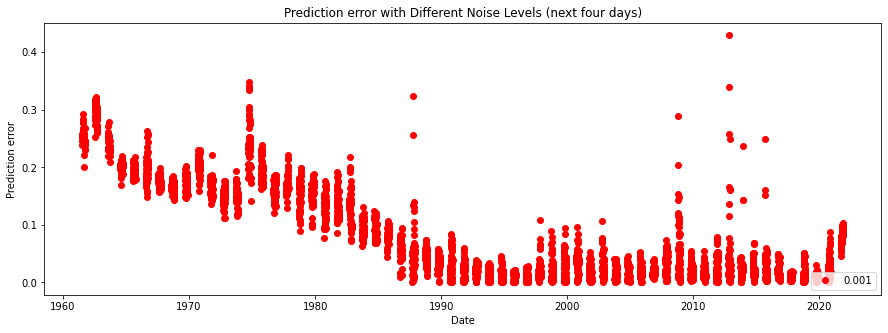

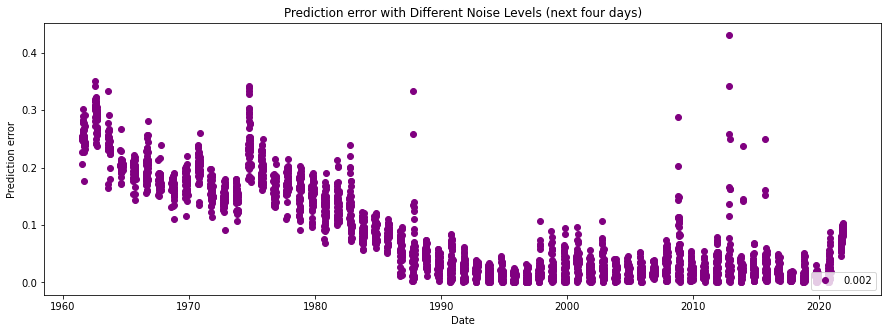

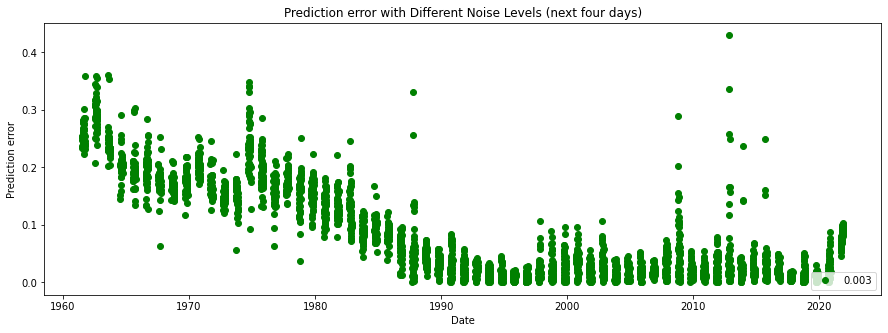

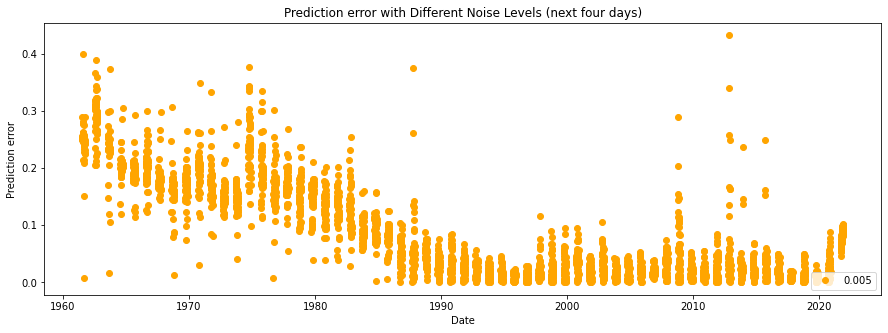

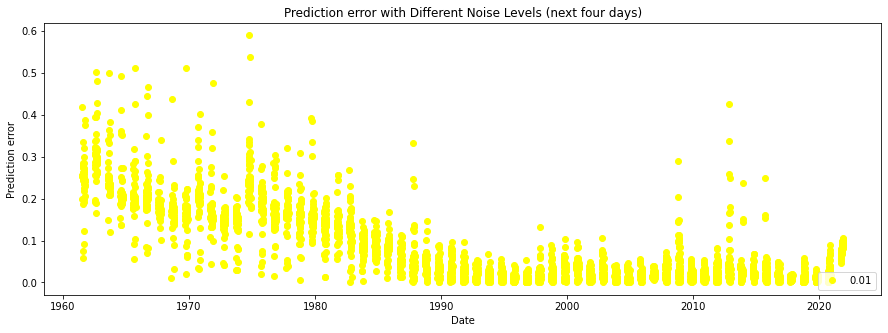

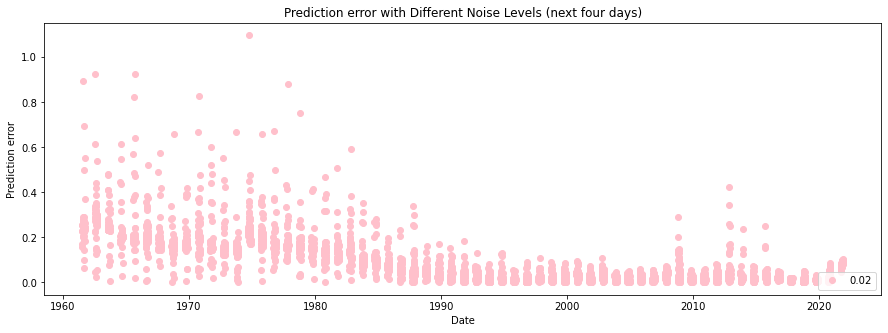

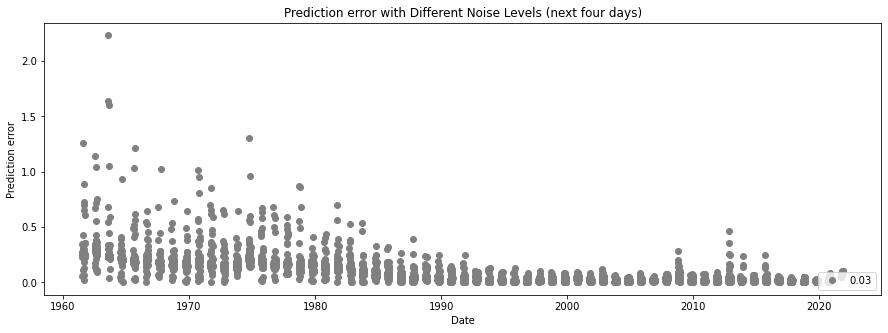

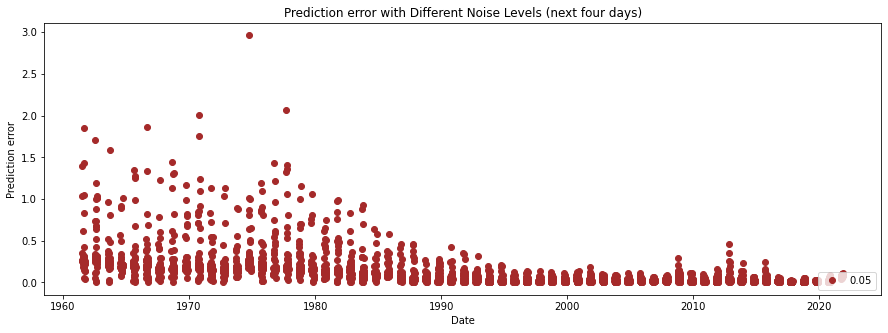

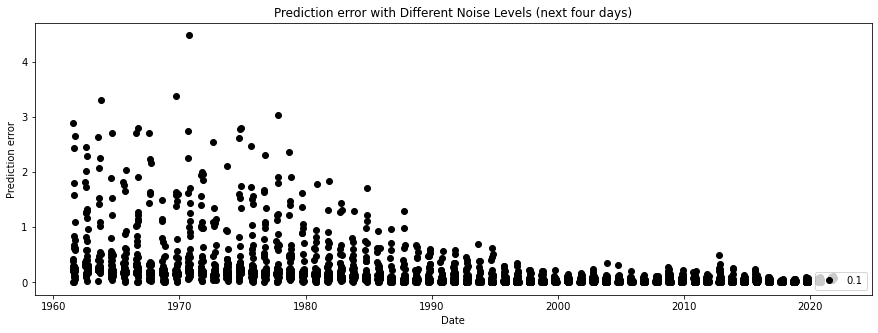

In [71]:
for i in range(len(std)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_test+ pd.Timedelta('3 day'), error_res_all[i], color=colors[i], lw=1, label = std[i], 
             marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next four days)')
    plt.legend(loc="lower right")  
    plt.show()

In [72]:
mean_test

[0.07870817465756544,
 0.060156999252721874,
 0.05394384683545825,
 0.056005407900931434,
 0.04071031202054765,
 0.044165199432489,
 0.04419164395045921,
 0.040152914157682386]

In [73]:
mean_train

[0.08049229290076389,
 0.06264542022490924,
 0.055790187357916764,
 0.05864110937806354,
 0.05262104017226452,
 0.05217164284537184,
 0.0587279902581091,
 0.0638977416257674]